In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [4]:
from warnings import simplefilter,filterwarnings
from sklearn.exceptions import DataConversionWarning
simplefilter(action='ignore',category = FutureWarning)
simplefilter(action='ignore',category = RuntimeWarning)
filterwarnings(action='ignore',category=DataConversionWarning)

## 0.0.1 Import Data

In [5]:
raw_data = pd.read_csv("corn_data.csv")
raw_data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1126,1127,1128,1129,1130,1131,1132,1133,1134,output
0,0,1,-1,1,1,1,0,1,-1,1,...,-1,1,-1,1,1,-1,0,0,-1,2.516485
1,1,1,-1,1,1,-1,-1,1,-1,1,...,-1,1,-1,0,1,-1,-1,1,0,1.640909
2,2,0,1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,1,1,-1,-1,1,0,0.416348
3,3,1,1,1,0,-1,1,1,-1,1,...,-1,1,-1,-1,1,-1,-1,1,0,1.338558
4,4,1,1,1,0,-1,-1,1,0,1,...,-1,1,-1,0,-1,-1,1,1,0,1.729517


In [6]:
X = raw_data.iloc[:,1:-1]
y = raw_data.iloc[:,-1:]
print("X shape:",X.shape)
print("y shape:",y.shape)
print("Min y:",min(np.array(y))[0])
print("Max y:",max(np.array(y))[0])

X shape: (264, 1135)
y shape: (264, 1)
Min y: 0.0117532464005208
Max y: 4.9270454514617015


## 0.0.2 Visualize our data

We would like to visualize how the values of the output are distributed, using a histogram. 

Since our output values range from 0.01 to 4.92, it makes sense to display our output in bins from [0-1] to [4-5]

Text(0.5, 1.0, 'Output Distribution')

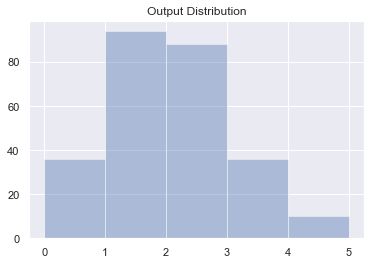

In [7]:
sns.distplot(y,bins=[0,1,2,3,4,5],kde=False)
plt.title("Output Distribution")


Remark: Most of our values falls within [1-3]. The highest yields [4-5], unsurprisingly, are the fewest

## 0.0.3 Construct a Scoring system

### i- Scorer class
First construct a scoring class. This will keep track of all our scores.

In [8]:
class ScoreSheet:
    def __init__(self,title):
        self.title=title
        self.sheet = pd.DataFrame({})
        
    def add_score(self,name,list):
        self.sheet.loc[name]=list
        
    def add_score(self,series):
        self.sheet = self.sheet.append(series)
        
    def get_pred_labels(self):
        return list(self.sheet.columns)
    
    def get_test_labels(self):
        return list(self.sheet.index)
    
    def get_test(self,name):
        return self.sheet.loc[name]
    
    def get_predictor(self,name):
        return list(self.sheet[name])
    
    def get_sheet(self):
        return self.sheet
    
    

### ii - Test class

In [9]:
from random import random
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split  


class Test:
    def __init__(self,X,y):
        self.settings = Settings(X,y)
  
    # 
    def split(self):
        """
        Split the data into test sets and training sets. Will split according to stratify, bias
        
        Return: lists - X_train, X_test, y_train, y_test 
        """
        sttg = self.settings
        if sttg.bias > 0:
            X_train, X_test, y_train, y_test = sttg.biased_split()
        else:
            X_train, X_test, y_train, y_test = train_test_split(sttg.X,sttg.y,test_size=sttg.split,stratify=sttg.strf)
        return X_train, X_test, y_train, y_test    
    
    def fit_predict(self,clf_name,X_train, X_test, y_train, y_test):
        sttg = self.settings
        clf = sttg.predictor(clf_name)
        clf.fit(X_train,y_train)
        y_train_predicted = clf.predict(X_train)
        y_test_predicted  = clf.predict(X_test)
        return np.reshape(y_train_predicted,(y_train.shape)),np.reshape(y_test_predicted,(y_test.shape))
    
    # Determine the R2 Score for a list of predictors
    def mult_R2(self,predictors):
        train_r2 = []
        test_r2 = []
        for clf_name in predictors:
            X_train, X_test, y_train, y_test = self.split()
            y_train_predicted, y_test_predicted = self.fit_predict(clf_name,X_train, X_test, y_train, y_test)
            train_r2.append(r2_score(y_train,y_train_predicted))
            test_r2.append(r2_score(y_test,y_test_predicted))
        return pd.Series(train_r2,index=predictors,name="Train R2"),pd.Series(test_r2,index=predictors,name="Test R2")
    
    def avg_R2(self,predictors,iterations):
        all_train_r2 = []
        all_test_r2 = []
        for i in range(iterations):
            train_r2,test_r2 = self.mult_R2(predictors)
            all_train_r2.append(list(train_r2))
            all_test_r2.append(list(test_r2))
        mean_train_r2 = [np.mean(i) for i in np.array(all_train_r2).T]
        mean_test_r2 = [np.mean(i) for i in np.array(all_test_r2).T]
        return pd.Series(mean_train_r2,index=predictors,name="Train R2"),pd.Series(mean_test_r2,index=predictors,name="Test R2")
    
    def FS_split(self,clf_name,fs_name,k,fs_split):
        sttg = self.settings
        fs = sttg.fs(clf_name,fs_name,k)
        X_train, X_test, y_train, y_test, = self.split() #Regular split
        X_train_FS, X_FS, y_train_FS, y_FS = train_test_split(X_train,y_train, test_size=fs_split) 
                                #Split a portion of train data to serve feature selection purpose
        fs.fit(X_FS,y_FS)  
        X_train_FS = fs.transform(X_train_FS) # Now transform remaining train data and test data
        X_test_FS = fs.transform(X_test)
        return X_train_FS, X_test_FS, y_train_FS, y_test

    def mult_FS(self,clf_name,fs_name,fs_list):
        train_r2 = []
        test_r2 = []
        for k in fs_list:
            X_train, X_test, y_train, y_test = self.split()
            X_train_FS, X_test_FS, y_train_FS, y_test_FS = self.FS_split(clf_name,fs_name,k=k,fs_split=0.2)
            y_train_predicted, y_test_predicted = test.fit_predict(clf_name,X_train_FS, X_test_FS, y_train_FS, y_test_FS)
            train_r2.append(r2_score(y_train_FS,y_train_predicted))
            test_r2.append(r2_score(y_test_FS,y_test_predicted))
        return pd.Series(train_r2,index=fs_list,name="Train"),pd.Series(test_r2,index=fs_list,name="Test")

    def avg_FS(self,clf_name,fs_name,fs_list,iterations,train_name,test_name):
        all_train_r2 = []
        all_test_r2 = []
        for i in range(iterations):
            train_r2,test_r2 = self.mult_FS(clf_name,fs_name,fs_list)
            all_train_r2.append(list(train_r2))
            all_test_r2.append(list(test_r2))
        mean_train_r2 = [np.mean(i) for i in np.array(all_train_r2).T]
        mean_test_r2 = [np.mean(i) for i in np.array(all_test_r2).T]
        return pd.Series(mean_train_r2,index=fs_list,name=train_name),pd.Series(mean_test_r2,index=fs_list,name=test_name) 

         

### iii - Settings class

Keep track of all the settings and predictors including split_size, stratification option, grid search, etc...

In [10]:
#Import predictors
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
#Import Feature Selection tools
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression

class Settings:
    def __init__(self,X,y):
        self.X = X
        self.y = y
        self.strf = None
        self.split = 0.2
        self.bias = 0
        self.bias_threshold = 3
        self.gs_mode = 'default'
        
    def predictor(self,clf_name):
        default = {"SVR":SVR(),'RFR':RandomForestRegressor(),
               "XGB":XGBRegressor(),"ADA":AdaBoostRegressor(),"lSVR":SVR(kernel='linear')}
        best = { # These are the values after I have ran through grid search values manually. Will give more details in later versions
            'SVR':SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,shrinking=True,cache_size=50,verbose=False),
            'RFR':RandomForestRegressor(
                    n_estimators=100,criterion='mse',max_depth=None,min_samples_split=15,min_samples_leaf=5,
                    min_weight_fraction_leaf=0.0,max_features='sqrt',max_leaf_nodes=None,min_impurity_decrease=0.0,
                    min_impurity_split=None,bootstrap=True,oob_score=False,n_jobs=None,random_state=None,verbose=0,warm_start=False,),
            'XGB':XGBRegressor(), # Will fill in in later versions
            'ADA':AdaBoostRegressor(base_estimator=None,n_estimators=100,learning_rate=1.0,loss='linear',random_state=None,)
                }
        if self.gs_mode == 'best':
            return best[clf_name]
        else:
            return default[clf_name]

    def fs(self,clf_name,fs_name,k):
        clf = self.predictor(clf_name)
        fs={"RFE":RFE(clf, n_features_to_select=k, step=.2),
           "KBest":SelectKBest(f_regression, k=k)}
        return fs[fs_name]
    
    def get_stratify(self):
        return self.strf
    
    def set_stratify(self,bool):
        if bool:
            self.strf = np.array(self.y,dtype="int")
        else:
            self.strf = None
            
    def get_y_stratified(self,y):
        return np.array(y,dtype="int")
    
    def get_num_features(self):
        return self.X.shape[1]
    
    def set(self,strf,split,bias,bias_threshold,gs_mode):
        self.strf = strf
        self.split = split
        self.bias = bias
        self.bias_threshold = bias_threshold
        self.gs_mode = gs_mode
        return self.strf,self.split,self.bias,self.bias_threshold

    
    def set_default(self):
        self.strf = None
        self.split = 0.2
        self.bias = 0
        self.bias_threshold = 3
        self.gs_mode = 'default'
        return self.strf,self.split,self.bias,self.bias_threshold,self.gs_mode
    
    def set_split(self,split):
        self.split = split
        
    def get_split(self):
        return self.split
    
    def set_bias(self,bias,threshold):
        self.bias = bias
        self.bias_threshold = threshold
        
    def set_gs_mode(self,gs_mode):
        self.gs_mode = gs_mode

            
    def biased_split(self):
        filt1 = raw_data["output"] >= self.bias_threshold #Filter out outputs that are higher than threshold
        filt2 = raw_data["output"] < self.bias_threshold
        df1 = raw_data[filt1]
        df2 = raw_data[filt2]

        X_021a = df1.iloc[:,1:-1]
        y_021a = df1.iloc[:,-1:]
        X_021b = df2.iloc[:,1:-1]
        y_021b = df2.iloc[:,-1:]

        X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_021a,y_021a,test_size=self.bias,
                                                        stratify=np.array(y_021a,dtype="int"))
        X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_021b,y_021b,test_size=self.split,
                                                        stratify=np.array(y_021b,dtype="int"))

        y_train = y_train_a.append(y_train_b)
        X_train = X_train_a.append(X_train_b)
        y_test = y_test_a.append(y_test_b)
        X_test = X_test_a.append(X_test_b)

        return X_train, X_test, y_train, y_test
    
    def print_settings(self):
        print(self.split,
            self.bias,
            self.bias_threshold, self.gs_mode)

### iv - Draw class

This class will help with the plotting of graphs in the ScoreSheet and Test

- v1.0

In [11]:
class Draw:
    
    def histogram(sr,hist,kde):
        sns.distplot(sr,bins=[0,1,2,3,4,5],hist=hist,kde=kde)
    
    def heatmap(ss,transpose,annot):
        if transpose:
            sheet = ss.get_sheet().T
        else:
            sheet = ss.get_sheet()
        ax=sns.heatmap(sheet,annot=annot, fmt=".3f",cmap="coolwarm", center = -0.1 ,
                       square = True,linewidths=.1,vmin=-1,vmax=1,cbar=False)
        plt.title(ss.title)
        plt.show()
    
    def lineplot(ss,cols):
        ax = plt.subplot()
        for name in cols:
            x = ss.get_test_labels()
            y = ss.get_predictor(name)
            plt.plot(x,y)
            ax.set_ylim([0.0,1.0])
        ax.legend()
        plt.show()
        
    def FS_catplot(ss,x,y):
        sheet = ss.get_sheet()
        df = sheet.iloc[0]
        for i in range(1,len(sheet.index)):
            df = df.append(sheet.iloc[i])
        df = pd.DataFrame(df)
        df[x]=df.index
        sns.catplot(x=x,y=y,data=df,palette="icefire",kind="point",aspect=1.7)
        
#     This version is deprecated
    def scatterplot(y,y_predicted,marker,color,draw_divider):
#         plt.subplot()
        plt.xlabel("Actual values")
        plt.ylabel("Predicted values")
        plt.plot(y, y_predicted, marker, color=color)
        if draw_divider:
            plt.plot(np.linspace(0,5,10),np.linspace(0,5,10),'b--')
            
    def scatterplot(name,x,x_label,y,y_label,fit_reg):
        df1 = pd.DataFrame({x_label:x.T,y_label:y.T})
#         df1[x_label] = df1["output"] 
#         df1[y_label]=pd.DataFrame(y)
        plt.title(name)
        plt.ylim(0,5)
        plt.xlim(0,5)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        sns.regplot(data=df1,x=x_label,y=y_label,fit_reg=fit_reg)


### v - Useful Functions

In [11]:
test = Test(X,y)

## 0.1.0 Raw R2 Score

In [23]:
test.settings.set_default()
train_sr,test_sr = test.mult_R2(["ADA","RFR","SVR","XGB"])

ss = ScoreSheet("Raw R2 Score")
ss.add_score(train_sr)
ss.add_score(test_sr)
print(ss.title)
ss.get_sheet().head()

Raw R2 Score


,ADA,RFR,SVR,XGB
Train R2,0.733403,0.882953,0.758356,1.000000
Test R2,0.108432,-0.023230,0.137471,0.106505


In [24]:
test.settings.set_default()
train_avg,test_avg = test.avg_R2(["ADA","RFR","SVR","XGB"],iterations=10)

ss = ScoreSheet("Average Raw R2")
ss.add_score(train_avg)
ss.add_score(test_avg)
print(ss.title)
ss.get_sheet().head()

Average Raw R2


,ADA,RFR,SVR,XGB
Train R2,0.752085,0.876626,0.757229,1.000000
Test R2,0.131240,0.153158,0.148079,-0.000642


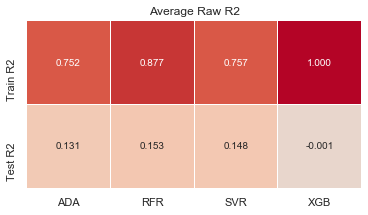

In [25]:
Draw.heatmap(ss,transpose=False,annot=True)

## 0.1.5 GridSearch



This module helps find the best version of the predictor models by trying different combinations of parameters 

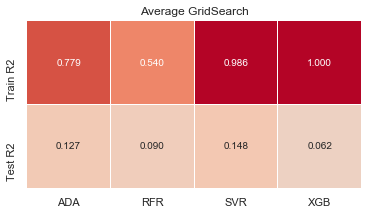

In [26]:
test.settings.set_default()
test.settings.set_gs_mode("best") #This will create 

train_avg,test_avg = test.avg_R2(["ADA","RFR","SVR","XGB"],iterations=10)

ss = ScoreSheet("Average GridSearch")
ss.add_score(train_avg)
ss.add_score(test_avg)
Draw.heatmap(ss,transpose=False,annot=True)

Finnding the best setting for the models helps, but can only get us so far. 

Let's look into different ways we can prepare our data in order to best assist the training process

## 0.2.0 Stratify our Data

What does stratification do to our data?

In [27]:
data = {"Original data":raw_data["output"],"Stratified data":list(np.array(test.settings.y,dtype='int').ravel())}
df1 = pd.DataFrame(data = data)
df1.head(10)

,Original data,Stratified data
0,2.516485,2
1,1.640909,1
2,0.416348,0
3,1.338558,1
4,1.729517,1
5,2.704476,2
6,1.971622,1
7,1.843582,1
8,2.082107,2
9,2.898305,2


We are creating bins for our data. In a way, we are turning the problem from regression into classification. 

This way we can use tools that are only available to classification to enhance our model

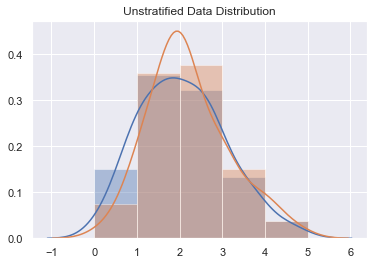

In [28]:
test.settings.set_default()
X_train, X_test, y_train, y_test = test.split()
plt.title("Unstratified Data Distribution")
Draw.histogram(y_train,hist=True,kde=True)
Draw.histogram(y_test,hist=True,kde=True)

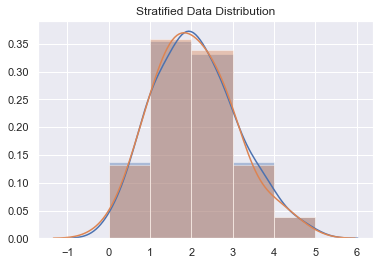

In [29]:
test.settings.set_default()
test.settings.set_stratify(True)
X_train, X_test, y_train, y_test = test.split()

plt.title("Stratified Data Distribution")
Draw.histogram(y_train,hist=True,kde=True)
Draw.histogram(y_test,hist=True,kde=True)

The distribution plots for train data and test data now sit on top of each other perfectly. 
This means the relative proportion of each bin to the total population (in both test data and train data) are maintained during the split.

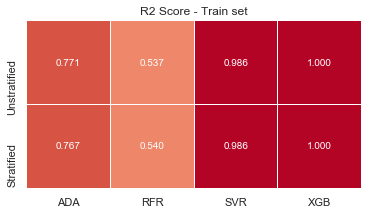

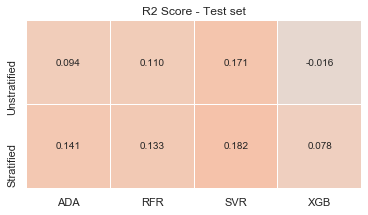

In [30]:
ss_trn = ScoreSheet("R2 Score - Train set")
ss_tst = ScoreSheet("R2 Score - Test set")

test.settings.set_default()
test.settings.set_gs_mode("best")

train_avg,test_avg = test.avg_R2(["SVR","ADA","RFR","XGB"],iterations=10)
train_avg.name = 'Unstratified'
test_avg.name = 'Unstratified'
ss_trn.add_score(train_avg)
ss_tst.add_score(test_avg)

test.settings.set_stratify(True)
train_avg,test_avg = test.avg_R2(["SVR","ADA","RFR","XGB"],iterations=10)
train_avg.name = 'Stratified'
test_avg.name = 'Stratified'
ss_trn.add_score(train_avg)
ss_tst.add_score(test_avg)

Draw.heatmap(ss_trn,transpose=False,annot=True)
Draw.heatmap(ss_tst,transpose=False,annot=True)

Stratification seems promising! ADA and especially SVR performed significantly better. Apparently class imbalance while training the data can have an impact on model performance and stratification helps

Still we want to do better. We are particularly interested in the higher yield datapoints

## 0.2.1 Biased Split
Let's look to manually increase bias towards higher yield. Let's make bins [3-4] and [4-5] more significant in the training process by introducing bias

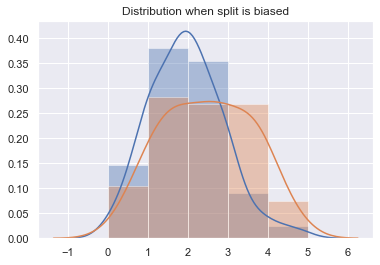

In [31]:
test.settings.set_bias(bias=0.5,threshold=3) 
#This means for outputs larger than threshold, the split is 0.5 instead of default split 0.2

X_train, X_test, y_train, y_test = test.split()
plt.title("Distribution when split is biased")
Draw.histogram(y_train,hist=True,kde=True)
Draw.histogram(y_test,hist=True,kde=True)

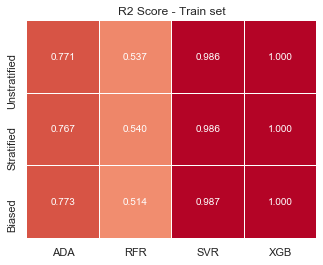

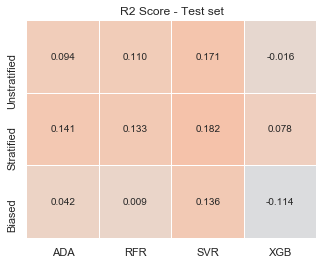

In [32]:
test.settings.set_default()
test.settings.set_gs_mode("best")
test.settings.set_bias(bias=0.5,threshold=3) 

train_avg,test_avg = test.avg_R2(["SVR","ADA","RFR","XGB"],iterations=10)
train_avg.name = 'Biased'
test_avg.name = 'Biased'
ss_trn.add_score(train_avg)
ss_tst.add_score(test_avg)

Draw.heatmap(ss_trn,transpose=False,annot=True)
Draw.heatmap(ss_tst,transpose=False,annot=True)

Unfortunately doing so doesn't seem to help with the R2 score in general as all models perform worse.

Let's see the actual performance of a test

In [ ]:
test.settings.set_default()
test.settings.set_gs_mode("best")
test.settings.set_bias(bias=0.5,threshold=3) 
# for clf_name in ["SVR","ADA","RFR","XGB"]:
clf_name = "ADA"
X_train, X_test, y_train, y_test = test.split()
y_train_predicted, y_test_predicted = test.fit_predict(clf_name,X_train, X_test, y_train, y_test)

list()


# 0.3 Feature Selection

## 0.3.1 Recursive Feature Elimination

In [ ]:
test = Test(X,y)

In [ ]:
test.settings.set_default()
test.settings.set_gs_mode("best")
# test.settings.set_bias(bias=0.5,threshold=3) 
                #This means for outputs larger than threshold, the split is 0.5 instead of default split 0.2
X_train, X_test, y_train, y_test = test.split()
X_train_FS, X_test_FS, y_train_FS, y_test_FS = test.FS_split("ADA","RFE",k=500,fs_split=0.2)
print("Shape before FS: ")
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)
print("Shape after FS: ")
print("X_train_FS: ",X_train_FS.shape)
print("X_test_FS: ",X_test_FS.shape)

In [ ]:
test.settings.set_default()
test.settings.set_gs_mode("best")
test.settings.set_stratify(True)  

n_feature_list=np.arange(50,test.settings.get_num_features(),50) #[50,100,...,1050,1100]
test_instances = 5

def RFE_split_transform(test,clf_name,k,fs_split):
    sttg = test.settings
    X_train, X_test, y_train, y_test, = train_test_split(X,y, test_size=fs_split) 
                            #Split a portion of train data to serve feature selection purpose
    clf = sttg.predictor(clf_name)
    fs = RFE(clf,n_features_to_select=k,step=0.2)
    fs.fit(X_train,y_train)  
    X_train_FS = fs.transform(X_train) # Now transform remaining train data and test data
    X_test_FS = fs.transform(X_test)
    return X_train_FS, X_test_FS, y_train, y_test



X_train_FS, X_test_FS, y_train, y_test = RFE_split_transform(test,"ADA",k=500,fs_split=0.2)
y_train_predicted, y_test_predicted = test.fit_predict("ADA",X_train_FS, X_test_FS, y_train, y_test)
print(r2_score(y_train,y_train_predicted))
print(r2_score(y_test,y_test_predicted))


In [ ]:
def mult_RFE(test,clf_name,fs_list):
    train_r2 = []
    test_r2 = []
    for k in fs_list:
        X_train_FS, X_test_FS, y_train_FS, y_test_FS = RFE_split_transform(test,clf_name,k=k,fs_split=0.2)
        y_train_predicted, y_test_predicted = test.fit_predict(clf_name,X_train_FS, X_test_FS, y_train_FS, y_test_FS)
        train_r2.append(r2_score(y_train_FS,y_train_predicted))
        test_r2.append(r2_score(y_test_FS,y_test_predicted))
    return pd.Series(train_r2,index=fs_list,name="Train"),pd.Series(test_r2,index=fs_list,name="Test")

def avg_RFE(test,clf_name,fs_list,iterations,train_name,test_name):
    all_train_r2 = []
    all_test_r2 = []
    for i in range(iterations):
        train_r2,test_r2 = mult_RFE(test,clf_name,fs_list)
        all_train_r2.append(list(train_r2))
        all_test_r2.append(list(test_r2))
    mean_train_r2 = [np.mean(i) for i in np.array(all_train_r2).T]
    mean_test_r2 = [np.mean(i) for i in np.array(all_test_r2).T]
    return pd.Series(mean_train_r2,index=fs_list,name=train_name),pd.Series(mean_test_r2,index=fs_list,name=test_name)




In [ ]:
test.settings.set_default()
test.settings.set_gs_mode("best")
test.settings.set_stratify(True)  

n_feature_list=np.arange(50,test.settings.get_num_features(),50) #[50,100,...,1050,1100]
test_instances = 5

n_feature_list=np.arange(50,test.settings.get_num_features(),50) #[50,100,...,1050,1100]
test_instances = 5
fs_name = "RFE"

for clf_name in ["ADA","RFR","XGB"]: 
    train_name = clf_name+" "+fs_name+" Trn Avg"
    test_name = clf_name+" "+fs_name+" Tst Avg"
    ss_test = ScoreSheet(test_name)
    ss_train = ScoreSheet(train_name)
    
    # This loop accounts for the variance bar in the plot
    for i in range(test_instances):
        train_avg,test_avg=avg_RFE(test,clf_name,n_feature_list,3,train_name,test_name)
        ss_train.add_score(train_avg)
        ss_test.add_score(test_avg)
    Draw.FS_catplot(ss_test,"Num features",test_name)
    plt.title(ss_test.title)
    plt.show()

In [ ]:
test.settings.set_default()
test.settings.set_gs_mode("best")
test.settings.set_stratify(True)   


n_feature_list=np.arange(50,test.settings.get_num_features(),50) #[50,100,...,1050,1100]
test_instances = 5
fs_name = "RFE"

for clf_name in ["ADA","RFR","XGB"]:
    train_name = clf_name+" "+fs_name+" Trn Avg"
    test_name = clf_name+" "+fs_name+" Tst Avg"
    ss_test = ScoreSheet(test_name)
    ss_train = ScoreSheet(train_name)

    # This loop accounts for the variance bar in the plot
    for i in range(test_instances):
        train_avg,test_avg=test.avg_FS(clf_name,fs_name,n_feature_list,3,train_name,test_name)
        ss_train.add_score(train_avg)
        ss_test.add_score(test_avg)
    Draw.FS_catplot(ss_test,"Num features",test_name)
    plt.title(ss_test.title)
    plt.show()


## 0.3.2 Select KBest

In [ ]:
test.settings.set_default()
test.settings.set_gs_mode("best")
test.settings.set_stratify(True)   


n_feature_list=np.arange(50,test.settings.get_num_features(),50) #[50,100,...,1050,1100]
test_instances = 5
fs_name = "KBest"

for clf_name in ["ADA","RFR","XGB"]: 
    train_name = clf_name+" "+fs_name+" Trn Avg"
    test_name = clf_name+" "+fs_name+" Tst Avg"
    ss_test = ScoreSheet(test_name)
    ss_train = ScoreSheet(train_name)
    
    # This loop accounts for the variance bar in the plot
    for i in range(test_instances):
        train_avg,test_avg=test.avg_FS(clf_name,fs_name,n_feature_list,3,train_name,test_name)
        ss_train.add_score(train_avg)
        ss_test.add_score(test_avg)
    Draw.FS_catplot(ss_test,"Num features",test_name)
    plt.title(ss_test.title)
    plt.show()


In [ ]:
### Deprecated versions' graph (Code won't work but the graph is still valid)

## 0.4 Oversampling

## 0.4.1 SMOTE

In [210]:
from imblearn.over_sampling import SMOTE,SVMSMOTE

In [211]:
def SMOTE_split(test,mode,split):
    sttg = test.settings
    X_train, X_test, y_train, y_test = test.split()
    y_train_strf = np.array(y_train,dtype='int')
    dist = y_train - y_train_strf
    if mode == "SVM":
        sm = SVMSMOTE()
    else:
        sm = SMOTE()
    #SMOTE on train set
    X_res, y_res = sm.fit_resample(X_train, y_train_strf)
    return X_train, X_test, y_train, y_test, X_res, y_res, dist



Text(0.5, 1.0, 'SMOTEd Training set vs Test set distribution')

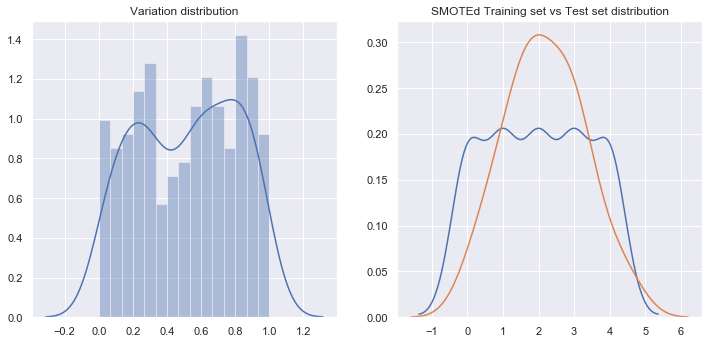

In [212]:
test = Test(X,y)
test.settings.set_default()
test.settings.set_gs_mode("best")
# test.settings.set_bias(0.4,3)

X_train, X_test, y_train, y_test,X_res, y_res, dist = SMOTE_split(test,"default",0.3)
num = 15

plt.figure(figsize=(12, 12))
plt.subplot(221)
sns.distplot(dist,bins=[1/num * i for i in range(num+1)])
plt.title("Variation distribution")

plt.subplot(222)
sns.distplot(y_res,bins=[0,1,2,3,4,5],hist=False,kde =True)
sns.distplot(y_test,bins=[0,1,2,3,4,5],hist=False,kde =True)
plt.title("SMOTEd Training set vs Test set distribution")

0.9953170143968867
-0.23245551680573917
0.8868726133661572
-0.2798195248925528


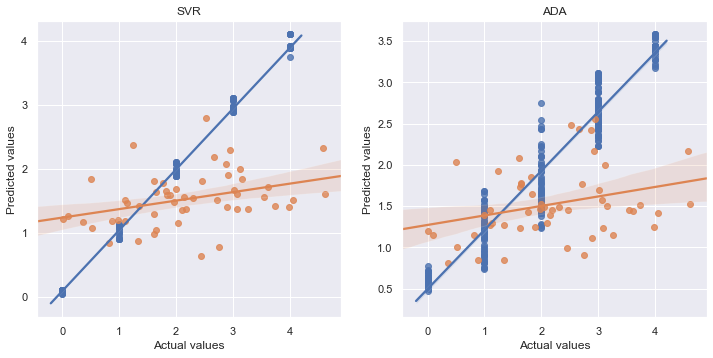

In [215]:

def scatterplot(name,x,x_label,y,y_label,fit_reg,color):
    df1 = pd.DataFrame({x_label:x,y_label:y})
    plt.title(name)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    sns.regplot(data=df1,x=x_label,y=y_label,fit_reg=fit_reg,color=color)
    
plt.figure(figsize=(12, 12))
plt.subplot(221)
y_train_predicted,y_test_predicted = test.fit_predict("SVR",X_res,X_test,y_res,y_test)
scatterplot("SVR", np.array(y_res).ravel(),"Actual values",np.array(y_train_predicted).ravel(),"Predicted values",True,None)
scatterplot("SVR", np.array(y_test).ravel(),"Actual values",np.array(y_test_predicted).ravel(),"Predicted values",True,None)
print(r2_score(y_res,y_train_predicted))
print(r2_score(y_test,y_test_predicted))

plt.subplot(222)
y_train_predicted,y_test_predicted = test.fit_predict("ADA",X_res,X_test,y_res,y_test)
scatterplot("ADA", np.array(y_res).ravel(),"Actual values",np.array(y_train_predicted).ravel(),"Predicted values",True,None)
scatterplot("ADA", np.array(y_test).ravel(),"Actual values",np.array(y_test_predicted).ravel(),"Predicted values",True,None)
print(r2_score(y_res,y_train_predicted))
print(r2_score(y_test,y_test_predicted))

In [39]:
nums_to_fill = len(y_res) - len(dist)
# for i in range(nums_to_fill):
rd = random()
rd

0.16234464465591614

### Adjust Data

In [276]:
def adjust_data(y_res,dist,num):
    bins = np.array([np.quantile(dist,1/num *i)for i in range(0,num+1)])
    print(bins)
    dist_extr = list(dist)
    
    nums_to_fill = len(y_res) - len(dist)
    for i in range(nums_to_fill):
        num = random()
        if len(np.where(bins>num)[0]) > 0:
            index = np.where(bins>num)[0][0]
        else:
            index = 0
        val = bins[index]
        dist_extr.append(val)
        
    y_res_adjusted = np.array(y_res).ravel() + np.array(dist_extr).ravel()
    return y_res_adjusted

In [277]:
test = Test(X,y)
test.settings.set_default()
test.settings.set_gs_mode("best")
test.settings.set_bias(0.4,3)

X_train, X_test, y_train, y_test,X_res, y_res, dist = SMOTE_split(test,"default",0.2)
y_res_adjusted = adjust_data(y_res,dist,num=20)

[0.00973838 0.062682   0.09977873 0.15244829 0.20556352 0.24229585
 0.30303456 0.38911247 0.44432181 0.52659057 0.58008861 0.61210118
 0.64098895 0.69570558 0.74482851 0.79055111 0.81633949 0.86759738
 0.90466864 0.94365179 0.99398249]


TypeError: 'list' object is not callable

In [278]:
data = {"Stratified data":y_res,"Adjusted data":y_res_adjusted}
df1 = pd.DataFrame(data = data)
df1["Difference"] = df1["Adjusted data"]- df1["Stratified data"]
df1.tail(25)

,Stratified data,Adjusted data,Difference
350,4,4.997652,0.997652
351,4,4.828678,0.828678
352,4,4.134244,0.134244
353,4,4.603792,0.603792
354,4,4.499831,0.499831
355,4,4.331315,0.331315
356,4,4.896234,0.896234
357,4,4.076628,0.076628
358,4,4.704476,0.704476
359,4,4.179032,0.179032


0.6501438117020292
0.01523452202457598
0.7132729544211441
-0.1214709649111172
0.6608592850162589
0.017084066867681935
0.6000286721530554
-0.24567328197063687


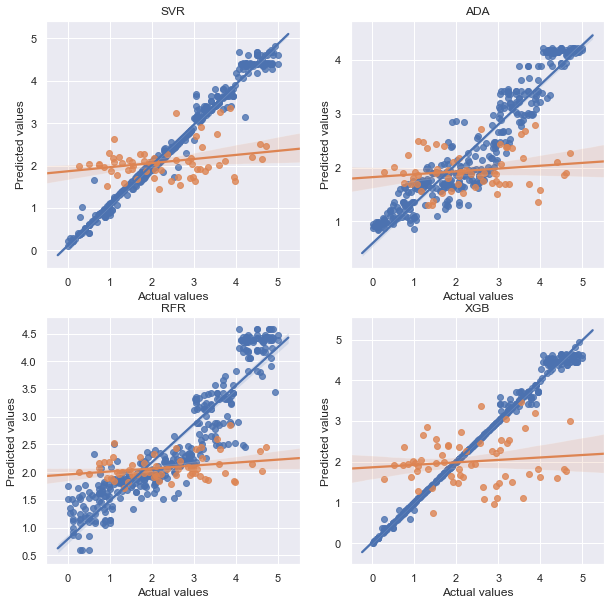

In [226]:
y_train_predicted,y_test_predicted = test.fit_predict("SVR",X_res,X_test,y_res_adjusted,y_test)
plt.figure(figsize=(10, 10))
plt.subplot(221)
scatterplot("SVR", np.array(y_res_adjusted).ravel(),"Actual values",np.array(y_train_predicted).ravel(),"Predicted values",True,None)
scatterplot("SVR", np.array(y_test).ravel(),"Actual values",np.array(y_test_predicted).ravel(),"Predicted values",True,None)

print(r2_score(y_res,y_train_predicted))
print(r2_score(y_test,y_test_predicted))

y_train_predicted,y_test_predicted = test.fit_predict("ADA",X_res,X_test,y_res_adjusted,y_test)
plt.subplot(222)

scatterplot("ADA", np.array(y_res_adjusted).ravel(),"Actual values",np.array(y_train_predicted).ravel(),"Predicted values",True,None)
scatterplot("ADA", np.array(y_test).ravel(),"Actual values",np.array(y_test_predicted).ravel(),"Predicted values",True,None)
print(r2_score(y_res,y_train_predicted))
print(r2_score(y_test,y_test_predicted))

y_train_predicted,y_test_predicted = test.fit_predict("RFR",X_res,X_test,y_res_adjusted,y_test)
plt.subplot(223)

scatterplot("RFR", np.array(y_res_adjusted).ravel(),"Actual values",np.array(y_train_predicted).ravel(),"Predicted values",True,None)
scatterplot("RFR", np.array(y_test).ravel(),"Actual values",np.array(y_test_predicted).ravel(),"Predicted values",True,None)
print(r2_score(y_res,y_train_predicted))
print(r2_score(y_test,y_test_predicted))

y_train_predicted,y_test_predicted = test.fit_predict("XGB",X_res,X_test,y_res_adjusted,y_test)
plt.subplot(224)

scatterplot("XGB", np.array(y_res_adjusted).ravel(),"Actual values",np.array(y_train_predicted).ravel(),"Predicted values",True,None)
scatterplot("XGB", np.array(y_test).ravel(),"Actual values",np.array(y_test_predicted).ravel(),"Predicted values",True,None)
print(r2_score(y_res,y_train_predicted))
print(r2_score(y_test,y_test_predicted))

In [136]:
test = Test(X,y)
test.settings.set_default()
test.settings.set_gs_mode("best")
test.settings.set_bias(0.4,3)

X_train, X_test, y_train, y_test,X_res, y_res, dist = SMOTE_split(test,"default",0.2)
y_res_adjusted = adjust_data(y_res,dist,num=20)

y_train_res_predicted,y_test_predicted = test.fit_predict("SVR",X_res,X_test,y_res_adjusted,y_test)

# scatterplot("SVR", np.array(y_res_adjusted).ravel(),"Actual values",np.array(y_train_predicted).ravel(),"Predicted values",True,"grey")
# scatterplot("SVR", np.array(y_train).ravel(),"Actual values",np.array(y_train_predicted).ravel(),"Predicted values",True,None)
# scatterplot("SVR", np.array(y_test).ravel(),"Actual values",np.array(y_test_predicted).ravel(),"Predicted values",True,None)

# print(r2_score(y_res,y_train_predicted))
# print(r2_score(y_test,y_test_predicted))

[0.00973838 0.04873084 0.07662771 0.13424429 0.17903201 0.24229585
 0.2913403  0.33131526 0.41387453 0.49983111 0.54185101 0.60379193
 0.64624953 0.70447559 0.74930999 0.79055111 0.82867844 0.8663632
 0.89623399 0.94365179 0.99765188]


## 0.4.2 KMEANS SMOTE

In [67]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC,
                                    KMeansSMOTE)

In [304]:
kmSmt = KMeansSMOTE(k_neighbors = 5)

In [324]:
test = Test(X,y)

test.settings.set_default()
test.settings.set_gs_mode("best")
test.settings.set_stratify(True)

In [325]:
X_train, X_test, y_train, y_test = test.split()
y_train_strf = np.array(y_train,dtype='int')
y = np.array(y,dtype='int')

dist = y_train - y_train_strf

In [326]:
sm = KMeansSMOTE(k_neighbors = 2,cluster_balance_threshold = 0.1) #Anything higher than 0.1 gives error

In [327]:
X_res, y_res = sm.fit_resample(X_train, y_train) #SMOTE on train set
y_res

array([1, 3, 2, 1, 2, 1, 1, 1, 3, 3, 2, 2, 1, 2, 1, 0, 4, 1, 0, 2, 3, 2,
       2, 0, 1, 1, 0, 0, 1, 2, 0, 2, 1, 1, 0, 2, 1, 3, 2, 2, 1, 1, 3, 2,
       2, 2, 0, 2, 1, 2, 1, 0, 0, 0, 3, 1, 1, 0, 1, 1, 4, 2, 0, 0, 0, 1,
       1, 1, 1, 3, 3, 3, 2, 2, 0, 0, 3, 1, 1, 2, 2, 3, 3, 3, 1, 2, 1, 2,
       2, 2, 1, 1, 3, 1, 2, 2, 0, 2, 0, 1, 2, 1, 1, 2, 1, 2, 1, 1, 3, 3,
       1, 1, 0, 2, 1, 0, 1, 1, 1, 2, 2, 0, 2, 3, 2, 2, 2, 3, 0, 1, 1, 2,
       1, 3, 2, 1, 1, 1, 2, 3, 2, 1, 2, 1, 1, 1, 1, 2, 3, 1, 3, 1, 4, 0,
       4, 2, 3, 1, 2, 2, 1, 4, 3, 0, 1, 3, 1, 2, 3, 1, 0, 2, 1, 2, 0, 3,
       1, 0, 2, 3, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 4, 2, 2, 0, 2, 4, 2,
       1, 2, 2, 2, 1, 2, 2, 1, 4, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

R2 for SVR
0.9947405602705262
0.2229937530561753
R2 for ADA
0.8791495182375249
0.1884718394143673
R2 for RFR
0.8656392487244502
0.1883248043968495
R2 for XGB
0.9999998970781736
-0.020564019142436996


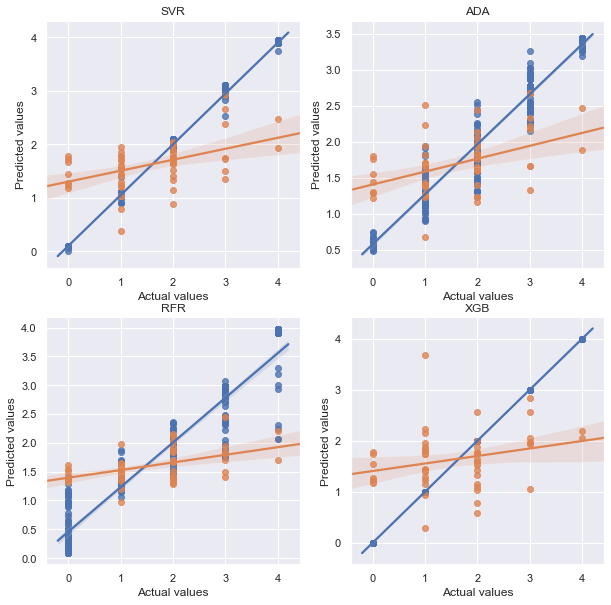

In [328]:
plt.figure(figsize=(10, 10))
clf_names = ["SVR","ADA","RFR","XGB"]
subplt = [221,222,223,224]
for clf,sub in zip(clf_names,subplt):
    y_train_predicted,y_test_predicted = test.fit_predict(clf,X_res,X_test,y_res,y_test)
    plt.subplot(sub)
    scatterplot(clf, np.array(y_res).ravel(),"Actual values",np.array(y_train_predicted).ravel(),"Predicted values",True,None)
    scatterplot(clf, np.array(y_test).ravel(),"Actual values",np.array(y_test_predicted).ravel(),"Predicted values",True,None)
    print("R2 for "+clf)
    print(r2_score(y_res,y_train_predicted))
    print(r2_score(y_test,y_test_predicted))


## 0.5 Clustering

See if we can find the correlation between input similarity and ouput

In [235]:
test = Test(X,y)

test.settings.set_default()
test.settings.set_stratify(True)

X_train, X_test, y_train, y_test = test.split()

In [236]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [237]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=random_state)
y_train_pred = kmeans.fit_predict(X_train_pca)
y_pred = kmeans.predict(X_test_pca)

In [238]:
y_train_pred

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0])

Text(0.5, 1.0, 'Clustering of Test Data')

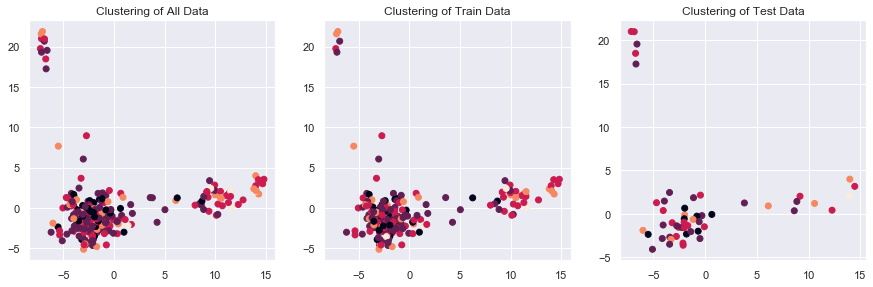

In [253]:
ax = plt.figure(figsize=(15, 15))
sns.set(style="darkgrid")
# Incorrect number of clusters

plt.subplot(331)
plt.scatter(X_pca[:,0], X_pca[:,1],c = np.array(y,dtype="int").ravel())
plt.title("Clustering of All Data")

plt.subplot(332)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1],c=np.array(y_train,dtype="int").ravel())
plt.title("Clustering of Train Data")

plt.subplot(333)
plt.scatter(X_test_pca[:,0], X_test_pca[:,1],c=np.array(y_test,dtype="int").ravel())
plt.title("Clustering of Test Data")


In [254]:
def make_bins(data,bin_edges):
    newList = []
    for num in data:
        i = 0;
        while i < len(bin_edges) and num >= bin_edges[i]:
            i+=1
        newNum = bin_edges[max(0,i-1)]
        newList.append(newNum)
    return newList

Text(0.5, 1.0, 'Clustering of Test Data')

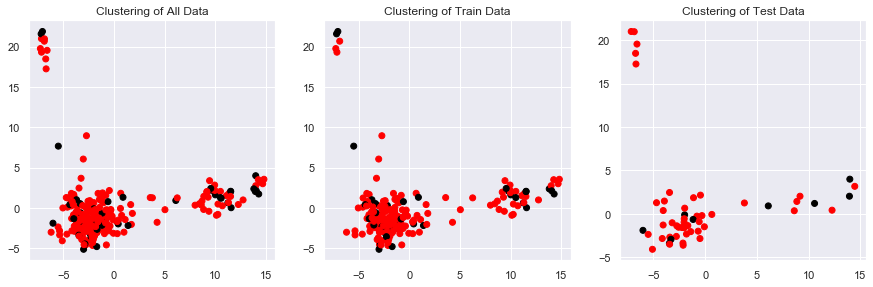

In [275]:
bins3 = [0,3]

plt.figure(figsize=(15, 15))
sns.set(style="darkgrid")

ax = plt.subplot(331)
plt.scatter(X_pca[:,0], X_pca[:,1],c=make_bins(np.array(y),bins3),cmap=plt.get_cmap("flag"))
plt.title("Clustering of All Data")

plt.subplot(332)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1],c= make_bins(np.array(y_train),bins3),cmap=plt.get_cmap("flag"))
plt.title("Clustering of Train Data")

plt.subplot(333)
plt.scatter(X_test_pca[:,0], X_test_pca[:,1],c=make_bins(np.array(y_test),bins3),cmap=plt.get_cmap("flag"))
plt.title("Clustering of Test Data")

### 0.6 Testing Binning Strategies

In [1]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import preprocessing

In [27]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
#Import Feature Selection tools
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression

from random import random, randint
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split  

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC,
                                    KMeansSMOTE)

In [12]:
#Strategy = Uniform
n_bins = 5
binner_qtl = KBinsDiscretizer(n_bins=n_bins, encode='ordinal',strategy='quantile')
binner_km = KBinsDiscretizer(n_bins=n_bins, encode='ordinal',strategy='kmeans')
binner_uni= KBinsDiscretizer(n_bins=n_bins, encode='ordinal',strategy='uniform')
y_b = y.copy()
y_b["class_quantile"] = binner_qtl.fit_transform(np.array(y_b["output"]).reshape(264,1))
y_b["class_kmeans"] = binner_km.fit_transform(np.array(y_b["output"]).reshape(264,1))
y_b["class_uniform"] = binner_uni.fit_transform(np.array(y_b["output"]).reshape(264,1))

uniform edges [array([0.01175325, 0.99481169, 1.97787013, 2.96092857, 3.94398701,
       4.92704545])]
kmeans edges [array([0.01175325, 1.1845431 , 1.94995124, 2.64852479, 3.48781605,
       4.92704545])]
quantile edges [array([0.01175325, 1.20853793, 1.78806113, 2.30033066, 2.93194329,
       4.92704545])]


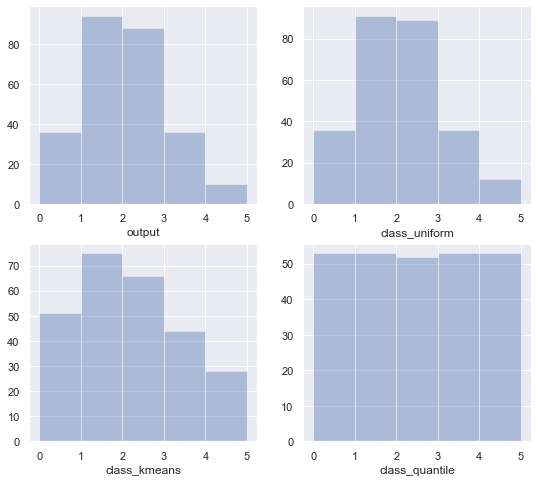

In [14]:
plt.figure(figsize=(9, 8))
plt.subplot(221)
sns.distplot(y_b["output"],bins=[0,1,2,3,4,5],hist=True,kde=False)
plt.subplot(222)
sns.distplot(y_b["class_uniform"],bins=[0,1,2,3,4,5],hist=True,kde=False)
plt.subplot(223)
sns.distplot(y_b["class_kmeans"],bins=[0,1,2,3,4,5],hist=True,kde=False)
plt.subplot(224)
sns.distplot(y_b["class_quantile"],bins=[0,1,2,3,4,5],hist=True,kde=False)
print("uniform edges" ,binner_uni.bin_edges_)
print("kmeans edges" ,binner_km.bin_edges_)
print("quantile edges" ,binner_qtl.bin_edges_)

In [15]:
y_b.head(10)

,output,class_quantile,class_kmeans,class_uniform
0,2.516485,3.0,2.0,2.0
1,1.640909,1.0,1.0,1.0
2,0.416348,0.0,0.0,0.0
3,1.338558,1.0,1.0,1.0
4,1.729517,1.0,1.0,1.0
5,2.704476,3.0,3.0,2.0
6,1.971622,2.0,2.0,1.0
7,1.843582,2.0,1.0,1.0
8,2.082107,2.0,2.0,2.0
9,2.898305,3.0,3.0,2.0


In [16]:
def make_bins(data,bin_edges):
    newList = []
    for num in data:
        i = 0;
        while i < len(bin_edges) and num >= bin_edges[i]:
            i+=1
        newNum = bin_edges[max(0,i-1)]
        newList.append(newNum)
    return newList

In [18]:
y_b.loc[:,"binned_quantile"] = make_bins(y_b["output"],binner_qtl.bin_edges_[0])
y_b.loc[:,"binned_kmeans"] = make_bins(y_b["output"],binner_km.bin_edges_[0])
y_b.loc[:,"binned_uniform"] = make_bins(y_b["output"],binner_uni.bin_edges_[0])

y_b.head()

,output,class_quantile,class_kmeans,class_uniform,binned_quantile,binned_kmeans,binned_uniform
0,2.516485,3.0,2.0,2.0,2.300331,1.949951,1.977870
1,1.640909,1.0,1.0,1.0,1.208538,1.184543,0.994812
2,0.416348,0.0,0.0,0.0,0.011753,0.011753,0.011753
3,1.338558,1.0,1.0,1.0,1.208538,1.184543,0.994812
4,1.729517,1.0,1.0,1.0,1.208538,1.184543,0.994812


In [20]:
y_b["diff_quantile"] = y_b["output"]-y_b["binned_quantile"]
y_b["diff_kmeans"] = y_b["output"]-y_b["binned_kmeans"]
y_b["diff_uniform"] = y_b["output"]-y_b["binned_uniform"]
y_b.drop(labels=["class_quantile","class_kmeans","class_uniform"],axis=1).head()

,output,binned_quantile,binned_kmeans,binned_uniform,diff_quantile,diff_kmeans,diff_uniform
0,2.516485,2.300331,1.949951,1.977870,0.216155,0.566534,0.538615
1,1.640909,1.208538,1.184543,0.994812,0.432371,0.456366,0.646097
2,0.416348,0.011753,0.011753,0.011753,0.404595,0.404595,0.404595
3,1.338558,1.208538,1.184543,0.994812,0.130020,0.154015,0.343746
4,1.729517,1.208538,1.184543,0.994812,0.520979,0.544974,0.734706


In [22]:
def find_neighbors_mean_y(X,y,X_res,n_neighbors):
    NN_obj = NearestNeighbors(n_neighbors = n_neighbors)
    NN_obj.fit(X)
    resampled_set_neighbors_list = NN_obj.kneighbors(X_res,n_neighbors)
    y_neighbors_distances = np.array(resampled_set_neighbors_list[0])
    y_neighbors = np.array([[y.loc[each_neighbor,"output"] for each_neighbor in each_data] for each_data in resampled_set_neighbors_list[1]])
    neighbors_mean_distances = np.array([np.mean(each_list) for each_list in y_neighbors_distances]).reshape(len(y_neighbors_distances),1)
    neighbors_mean_y_list = np.array([np.mean(each_list) for each_list in y_neighbors]).reshape(len(y_neighbors),1)
    return neighbors_mean_y_list, neighbors_mean_distances

mean_y, mean_dist =find_neighbors_mean_y(X,y,X,5)
y_b.loc[:,"neighbors_mean"] = mean_y
y_b.loc[:,"diff_neighbors_mean*"] = y_b["neighbors_mean"]-y_b["output"]
y_b.loc[:,"neighbors_mean_distances"] = mean_dist
a = np.array(1/(np.abs(y_b.loc[:,"diff_neighbors_mean*"])*y_b.loc[:,"neighbors_mean_distances"])).reshape(len(y_b.loc[:,"diff_neighbors_mean*"]),1)
y_b.loc[:,"neighbors_likeness_index"] = preprocessing.MinMaxScaler().fit_transform(a)

y_b.drop(columns = ["binned_quantile","binned_kmeans","binned_uniform","diff_quantile","diff_kmeans","diff_uniform"] ).head()

,output,class_quantile,class_kmeans,class_uniform,neighbors_mean,diff_neighbors_mean*,neighbors_mean_distances,neighbors_likeness_index
0,2.516485,3.0,2.0,2.0,2.599369,0.082884,7.591294,0.139012
1,1.640909,1.0,1.0,1.0,1.701757,0.060848,24.859739,0.056815
2,0.416348,0.0,0.0,0.0,1.910787,1.494439,25.238024,0.000623
3,1.338558,1.0,1.0,1.0,2.160018,0.821460,26.294076,0.002375
4,1.729517,1.0,1.0,1.0,2.049377,0.319860,24.340390,0.009649


In [23]:
stat_df = pd.DataFrame(columns = ["diff_quantile","diff_kmeans","diff_uniform"])
stat_df = stat_df.append(pd.Series([np.median(y_b["diff_quantile"]),np.median(y_b["diff_kmeans"]),
                          np.median(y_b["diff_uniform"]),np.median(y_b["diff_neighbors_mean*"])],
                       index=["diff_quantile","diff_kmeans","diff_uniform","diff_neighbors_mean*"],name = "median"))
stat_df = stat_df.append(pd.Series([np.var(y_b["diff_quantile"]),np.var(y_b["diff_kmeans"]),
                          np.var(y_b["diff_uniform"]),np.var(y_b["diff_neighbors_mean*"])],index=["diff_quantile","diff_kmeans","diff_uniform","diff_neighbors_mean*"],
                         name = "var"))
stat_df = stat_df.append(pd.Series([np.mean(y_b["diff_quantile"]),np.mean(y_b["diff_kmeans"]),
                          np.mean(y_b["diff_uniform"]),np.mean(y_b["diff_neighbors_mean*"])],index=["diff_quantile","diff_kmeans","diff_uniform","diff_neighbors_mean*"],
                         name = "mean"))
stat_df = stat_df.append(pd.Series([np.std(y_b["diff_quantile"]),np.std(y_b["diff_kmeans"]),
                          np.std(y_b["diff_uniform"]),np.std(y_b["diff_neighbors_mean*"])],index=["diff_quantile","diff_kmeans","diff_uniform","diff_neighbors_mean*"],
                         name = "std"))
stat_df

,diff_quantile,diff_kmeans,diff_uniform,diff_neighbors_mean*
median,0.351980,0.426716,0.533906,0.259856
var,0.134586,0.088834,0.087586,0.566238
mean,0.442396,0.454480,0.499496,0.208158
std,0.366859,0.298050,0.295949,0.752488


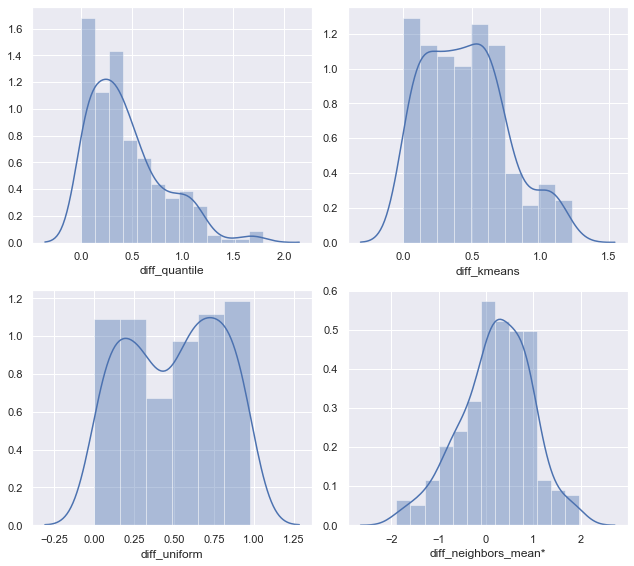

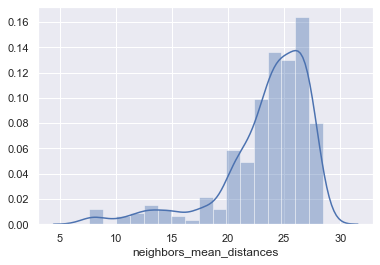

In [25]:
plt.figure(figsize=(9, 8))
plt.subplot(221)
sns.distplot(y_b["diff_quantile"],hist=True,kde=True)
plt.subplot(222)
sns.distplot(y_b["diff_kmeans"],hist=True,kde=True)
plt.subplot(223)
sns.distplot(y_b["diff_uniform"],hist=True,kde=True)
plt.subplot(224)
sns.distplot(y_b["diff_neighbors_mean*"],hist=True,kde=True)
plt.tight_layout()
plt.show()
sns.distplot(y_b["neighbors_mean_distances"],hist=True,kde=True)


#### Adjusting data based on same bin neighbor

In [43]:
class_col = "class_kmeans"
n_neighbors = 2
X_train, X_test, y_train, y_test = train_test_split(X,y_b,stratify = y_b[class_col])

sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train,y_train[class_col])

synthetic_data = pd.DataFrame()
for i in range(5):
    y_i = y_train[y_train[class_col]==i] # Get all y that is in bin i'th
    X_i = X_train.loc[y_i.index]         # Get all the corresponding X's in the train set
    X_res_i = X_res.loc[pd.Series.where(y_res,y_res==i).dropna().index] # Find all synthetic data that falls into that bin
    KNN = NearestNeighbors(n_neighbors = n_neighbors)
    KNN.fit(X_i)

    X_resampled_same_bin_neighbors_list = KNN.kneighbors(X_res_i,n_neighbors=n_neighbors) # Find in train set the nearest neighbor to each resampled data
    y_neighbors_distances = np.array(X_resampled_same_bin_neighbors_list[0])
    y_train_index = [[y_i.index[i] for i in each_data] for each_data in X_resampled_same_bin_neighbors_list[1]]
    y_neighbors = np.array([[y_i.loc[each_neighbor,"output"] for each_neighbor in each_data] for each_data in y_train_index])
    neighbors_mean_distances = np.array([np.mean(each_list) for each_list in y_neighbors_distances]).reshape(len(y_neighbors_distances),1)
    neighbors_mean_y_list = np.array([np.mean(each_list) for each_list in y_neighbors]).reshape(len(y_neighbors),1)
    X_res_i.loc[:,"output"]=neighbors_mean_y_list
    synthetic_data = synthetic_data.append(X_res_i)

# X_syn = synthetic_data.iloc[:,:-1].append(X_train)
# y_syn = synthetic_data.iloc[:,-1:].append(y_train)["output"]
X_syn = synthetic_data.iloc[:,:-1]
y_syn = synthetic_data.iloc[:,-1:]
synthetic_data
y_syn[X_syn.duplicated()==True]

,output
232,2.898771
239,2.945128
242,3.114997
243,2.947796
265,3.641956
267,3.608180
271,4.235334
272,4.399757
274,3.587484
276,3.641661


In [34]:
n_neighbors = 2
for class_col in ["class_quantile","class_uniform","class_kmeans"]:
    all_train_r2 = []
    all_test_r2 = []
    for j in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X,y_b,stratify = y_b[class_col])

        sm = SMOTE()
        X_res, y_res = sm.fit_resample(X_train,y_train[class_col])

        synthetic_data = pd.DataFrame()
        for i in range(5):
            y_i = y_train[y_train[class_col]==i]
            X_i = X_train.loc[y_i.index]
            X_res_i = X_res.loc[pd.Series.where(y_res,y_res==i).dropna().index]
            KNN = NearestNeighbors(n_neighbors = n_neighbors)
            KNN.fit(X_i)

            X_resampled_same_bin_neighbors_list = KNN.kneighbors(X_res_i,n_neighbors=n_neighbors)
            y_neighbors_distances = np.array(X_resampled_same_bin_neighbors_list[0])
            y_train_index = [[y_i.index[i] for i in each_data] for each_data in X_resampled_same_bin_neighbors_list[1]]
            y_neighbors = np.array([[y_i.loc[each_neighbor,"output"] for each_neighbor in each_data] for each_data in y_train_index])
            neighbors_mean_distances = np.array([np.mean(each_list) for each_list in y_neighbors_distances]).reshape(len(y_neighbors_distances),1)
            neighbors_mean_y_list = np.array([np.mean(each_list) for each_list in y_neighbors]).reshape(len(y_neighbors),1)
            X_res_i.loc[:,"output"]=neighbors_mean_y_list
            synthetic_data = synthetic_data.append(X_res_i)

        X_syn = synthetic_data.iloc[:,:-1].append(X_train)
        y_syn = synthetic_data.iloc[:,-1:].append(y_train)["output"]
        

        svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
                  shrinking=True,cache_size=50,verbose=False)
        svr.fit(X_syn,y_syn)      
        y_train_pred = svr.predict(X_train)
        y_test_pred = svr.predict(X_test)
        all_train_r2.append(r2_score(y_train['output'],y_train_pred))
        all_test_r2.append(r2_score(y_test['output'],y_test_pred))

    print(class_col+"_train",np.mean(all_train_r2))
    print(class_col+"_test",np.mean(all_test_r2))

class_quantile_train 0.9809357586111338
class_quantile_test 0.2045133644790539
class_uniform_train 0.9848195087087745
class_uniform_test 0.1881206796054285
class_kmeans_train 0.9863659963730249
class_kmeans_test 0.2199970962673922


### 0.7 Analyzing Successful Instances

So far all our efforts has not lead to much improvement. Though we have managed to improve the R2 score from the teens to the low twenties, on average, it has not improved much after that.

We do notice that some test instances do give very promising results, up to the mid thrities or so. Maybe we can try to analyze those success and reverse engineer them

In [83]:
all_train_r2 = []
all_test_r2 = []
splitted_data = []
for j in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X,y_b,stratify = y_b["class_uniform"],test_size = 0.30)
    svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
          shrinking=True,cache_size=50,verbose=False)
    svr.fit(X_train,y_train["output"])      
    y_train_pred = svr.predict(X_train)
    y_test_pred = svr.predict(X_test)
    r2_test_set = r2_score(y_test['output'],y_test_pred)
    if r2_test_set >= 0.3:
        all_train_r2.append(r2_score(y_train['output'],y_train_pred))
        all_test_r2.append(r2_score(y_test['output'],y_test_pred))
        splitted_data.append([X_train, X_test, y_train, y_test])
df_07 = pd.DataFrame([],columns=["test","train"])
df_07.loc[:,"test"] = all_test_r2
df_07.loc[:,"train"] = all_train_r2

In [93]:
df_07a = df_07[df_07.loc[:,"test"] >= 0.3]
df_07a

,test,train
0,0.306213,0.989187
1,0.317179,0.982073
2,0.314855,0.990122
3,0.313571,0.981221
4,0.325600,0.987356
5,0.300606,0.980876
6,0.315787,0.989488
7,0.322018,0.987587
8,0.336260,0.987573
9,0.330724,0.988285


In [94]:
X_train, X_test, y_train, y_test = splitted_data[8]
svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
      shrinking=True,cache_size=50,verbose=False)
svr.fit(X_train,y_train["output"])      
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)
print(r2_score(y_test['output'],y_test_pred))
print(r2_score(y_train['output'],y_train_pred))

0.33626012664217575
0.9875733745284772


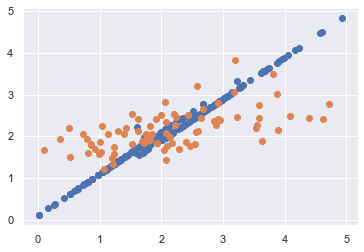

In [88]:
plt.scatter(y_train["output"],y_train_pred,cmap=plt.get_cmap("flag"))
plt.scatter(y_test["output"],y_test_pred,cmap=plt.get_cmap("flag"))

plt.show()

### Try to see if it works on synthetic data

In [97]:
class_col = "class_uniform"
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X,y_b,stratify = y_b[class_col])

sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train_1,y_train_1[class_col])
synthetic_data = pd.DataFrame()
for i in range(5):
    y_i = y_train_1[y_train_1[class_col]==i]
    X_i = X_train_1.loc[y_i.index]
    X_res_i = X_res.loc[pd.Series.where(y_res,y_res==i).dropna().index]
    KNN = NearestNeighbors(n_neighbors = n_neighbors)
    KNN.fit(X_i)

    X_resampled_same_bin_neighbors_list = KNN.kneighbors(X_res_i,n_neighbors=n_neighbors)
    y_neighbors_distances = np.array(X_resampled_same_bin_neighbors_list[0])
    y_train_index = [[y_i.index[i] for i in each_data] for each_data in X_resampled_same_bin_neighbors_list[1]]
    y_neighbors = np.array([[y_i.loc[each_neighbor,"output"] for each_neighbor in each_data] for each_data in y_train_index])
    neighbors_mean_distances = np.array([np.mean(each_list) for each_list in y_neighbors_distances]).reshape(len(y_neighbors_distances),1)
    neighbors_mean_y_list = np.array([np.mean(each_list) for each_list in y_neighbors]).reshape(len(y_neighbors),1)
    X_res_i.loc[:,"output"]=neighbors_mean_y_list
    synthetic_data = synthetic_data.append(X_res_i)
synthetic_data
X_syn = synthetic_data.iloc[:,:-1]
y_syn = synthetic_data.iloc[:,-1:]

In [98]:
y_pred = svr.predict(X_syn)
print(r2_score(y_syn['output'],y_pred))

0.7938833103783552


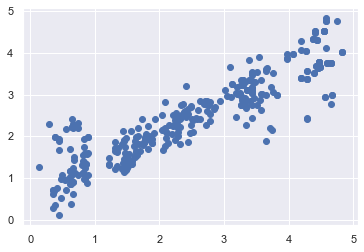

In [99]:
plt.scatter(y_syn["output"],y_pred,cmap=plt.get_cmap("flag"))
plt.show()

Let's try to do the other way around

In [150]:
class_col = "class_uniform"
n_neighbors = 2
def create_synthetic_data(X,y_b,class_col,n_neighbors):
    X_train, X_test, y_train, y_test = train_test_split(X,y_b,stratify = y_b[class_col])

    sm = SMOTE()
    X_res, y_res = sm.fit_resample(X_train,y_train[class_col])

    synthetic_data = pd.DataFrame()
    for i in range(5):
        y_i = y_train[y_train[class_col]==i] # Get all y that is in bin i'th
        X_i = X_train.loc[y_i.index]         # Get all the corresponding X's in the train set
        X_res_i = X_res.loc[pd.Series.where(y_res,y_res==i).dropna().index] # Find all synthetic data that falls into that bin
        KNN = NearestNeighbors(n_neighbors = n_neighbors)
        KNN.fit(X_i)

        X_resampled_same_bin_neighbors_list = KNN.kneighbors(X_res_i,n_neighbors=n_neighbors) # Find in train set the nearest neighbor to each resampled data
        y_neighbors_distances = np.array(X_resampled_same_bin_neighbors_list[0])
        y_train_index = [[y_i.index[i] for i in each_data] for each_data in X_resampled_same_bin_neighbors_list[1]]
        y_neighbors = np.array([[y_i.loc[each_neighbor,"output"] for each_neighbor in each_data] for each_data in y_train_index])
        neighbors_mean_distances = np.array([np.mean(each_list) for each_list in y_neighbors_distances]).reshape(len(y_neighbors_distances),1)
        neighbors_mean_y_list = np.array([np.mean(each_list) for each_list in y_neighbors]).reshape(len(y_neighbors),1)
        X_res_i.loc[:,"output"]=neighbors_mean_y_list
        synthetic_data = synthetic_data.append(X_res_i)

    return synthetic_data,X_train, X_test, y_train, y_test

#         X_syn = synthetic_data.iloc[:,:-1].append(X_train)
#         y_syn = synthetic_data.iloc[:,-1:].append(y_train)["output"]

synthetic_data,a,b,c,d = create_synthetic_data(X,y_b,class_col,n_neighbors)
synthetic_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1126,1127,1128,1129,1130,1131,1132,1133,1134,output
2,0,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,1,-1,1,1,-1,-1,1,0,0.672980
3,1,-1,1,-1,-1,0,1,-1,-1,-1,...,-1,1,-1,1,-1,-1,-1,1,0,0.892137
12,1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,1,-1,-1,1,-1,-1,-1,0,0.442654
19,1,1,1,0,-1,-1,1,-1,-1,-1,...,-1,0,-1,-1,-1,-1,-1,1,0,0.832023
33,1,-1,1,0,-1,-1,1,0,1,-1,...,-1,1,-1,0,-1,1,-1,1,0,0.470682


In [113]:
all_train_r2 = []
all_test_r2 = []
all_r2 = []
splitted_data = []
class_col = "class_uniform"
n_neighbors = 2
test_size = 0.5

for j in range(500):
    synthetic_data,X_train, X_test, y_train, y_test = create_synthetic_data(X,y_b,class_col,n_neighbors)
    X_syn = synthetic_data.iloc[:,:-1]
    y_syn = synthetic_data.iloc[:,-1:]
    
    svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
          shrinking=True,cache_size=50,verbose=False)
    svr.fit(X_syn,y_syn["output"]) 
    
    y_pred = svr.predict(X)
    y_train_pred = svr.predict(X_train)
    y_test_pred = svr.predict(X_test)
    r2_test = r2_score(y_test['output'],y_test_pred)
    if r2_test >= 0.3:
        all_r2.append(r2_score(y_b['output'],y_pred))
        all_train_r2.append(r2_score(y_train['output'],y_train_pred))
        all_test_r2.append(r2_score(y_test['output'],y_test_pred))
        splitted_data.append([X_syn,y_syn,X_train, X_test, y_train, y_test])
df_07b = pd.DataFrame([],columns=["all","test","train"])
df_07b.loc[:,"all"] = all_r2
df_07b.loc[:,"test"] = all_test_r2
df_07b.loc[:,"train"] = all_train_r2

In [114]:
df_07b

,all,test,train
0,0.803598,0.320319,0.952075
1,0.784068,0.301095,0.945649
2,0.773890,0.325263,0.944117
3,0.754326,0.301049,0.948080
4,0.803822,0.365367,0.952054
5,0.797957,0.344292,0.945700
6,0.776827,0.303340,0.944634
7,0.779835,0.312313,0.949636
8,0.810912,0.359309,0.949161
9,0.781778,0.303835,0.943877


In [121]:
X_syn,y_syn,X_train, X_test, y_train, y_test = splitted_data[4]
svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
      shrinking=True,cache_size=50,verbose=False)
svr.fit(X_syn,y_syn["output"]) 
y_pred = svr.predict(X_test)
print(r2_score(y_test['output'],y_pred))

0.3653672909373512


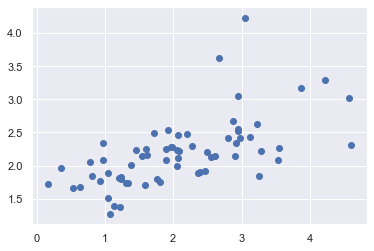

In [122]:
plt.scatter(y_test["output"],y_pred,cmap=plt.get_cmap("flag"))
plt.show()


In [160]:
class_col = "class_uniform"
n_neighbors = 3
synthetic_data,X_train, X_test, y_train, y_test = create_synthetic_data(X,y_b,class_col,n_neighbors)

X_syn = synthetic_data.iloc[:,:-1].append(X_train)
y_syn = synthetic_data.iloc[:,-1:].append(y_train)["output"]
X_syn = X_syn.drop_duplicates(keep=False)
y_syn = y_syn.iloc[X_syn.index]
print(len(X_syn),len(y_syn))
y_syn

70 70


187    2.498464
192    2.185749
193    2.373024
194    2.782896
195    2.319700
239    2.801856
3      3.593090
9      3.309517
18     3.196186
19     3.729886
25     3.410229
26     3.439641
34     3.309865
35     3.512924
42     3.148801
48     3.724192
49     3.443118
66     3.298472
87     3.578175
88     3.347960
103    3.396999
109    3.347960
125    3.549789
163    3.489798
182    3.671578
185    3.443118
190    3.553635
240    3.601001
241    3.475591
243    3.593090
         ...   
260    3.509168
261    3.419213
262    3.443118
263    3.578282
265    3.443118
267    3.335373
268    3.239954
269    3.377407
270    3.592363
271    3.334369
272    3.621213
273    3.593090
274    3.347960
275    3.499564
276    3.525079
277    3.348697
278    3.386942
8      4.186157
45     4.507061
63     4.507061
93     4.195854
118    4.174465
131    4.397824
150    4.144047
181    4.507061
286    4.283432
287    4.419483
299    4.152807
308    4.396836
311    4.009255
Name: output, Length: 70

In [212]:
all_train_r2 = []
all_test_r2 = []
all_r2 = []
splitted_data = []
class_col = "class_quantile"
n_neighbors = 2
for j in range(500):
    synthetic_data,X_train, X_test, y_train, y_test = create_synthetic_data(X,y_b,class_col,n_neighbors)
    X_syn = synthetic_data.iloc[:,:-1]
    y_syn = synthetic_data.iloc[:,-1:]

    svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
          shrinking=True,cache_size=50,verbose=False)
    svr.fit(X_syn,y_syn) 
    
    y_pred = svr.predict(X)
    y_train_pred = svr.predict(X_train)
    y_test_pred = svr.predict(X_test)
    r2_test = r2_score(y_test['output'],y_test_pred)
    if r2_test >= 0.2:
        all_r2.append(r2_score(y_b['output'],y_pred))
        all_train_r2.append(r2_score(y_train['output'],y_train_pred))
        all_test_r2.append(r2_score(y_test['output'],y_test_pred))
        splitted_data.append([X_syn,y_syn,X_train, X_test, y_train, y_test])
X_syn
        
df_07c = pd.DataFrame([],columns=["all","test","train"])
df_07c.loc[:,"all"] = all_r2
df_07c.loc[:,"test"] = all_test_r2
df_07c.loc[:,"train"] = all_train_r2

In [213]:
df_07c

,all,test,train
0,0.738466,0.230129,0.937901
1,0.758294,0.211794,0.935632
2,0.765547,0.204880,0.943430
3,0.787367,0.345368,0.931398
4,0.789955,0.272280,0.940023
5,0.788342,0.357036,0.948962
6,0.785818,0.218448,0.943619
7,0.764103,0.241946,0.949816
8,0.769496,0.251969,0.940930
9,0.762748,0.236884,0.940558


In [223]:
pd.DataFrame.where(df_07c.loc[:,"test"],df_07c.loc[:,"test"] == max(np.array(df_07c.loc[:,"test"]))).dropna()

114    0.398409
Name: test, dtype: float64

In [224]:
X_syn,y_syn,X_train, X_test, y_train, y_test = splitted_data[114]
svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
      shrinking=True,cache_size=50,verbose=False)
svr.fit(X_syn,y_syn["output"]) 
y_pred = svr.predict(X_test)
print(r2_score(y_test['output'],y_pred))

0.39840933624519703


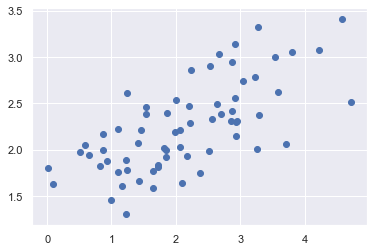

In [225]:
plt.scatter(y_test["output"],y_pred,cmap=plt.get_cmap("flag"))
plt.show()


### Try aggregating all the synthetic data

In [214]:
X_syn_07d = pd.DataFrame([])
y_syn_07d = pd.DataFrame([])
for i in range(len(splitted_data)):
    X_syn_07d = X_syn_07d.append(splitted_data[i][0])
    y_syn_07d = y_syn_07d.append(splitted_data[i][1])
    
X_syn_07d.index = [i for i in range(len(X_syn_07d))]
y_syn_07d.index = [i for i in range(len(y_syn_07d))]
X_syn_07d

,0,1,2,3,4,5,6,7,8,9,...,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134
0,1,-1,1,1,1,-1,-1,-1,1,-1,...,-1,-1,1,-1,-1,1,-1,-1,1,0
1,1,1,1,-1,-1,1,1,-1,1,-1,...,1,-1,0,-1,1,1,-1,-1,1,-1
2,1,-1,-1,-1,-1,1,1,-1,1,-1,...,1,-1,1,-1,-1,1,-1,-1,1,0
3,1,1,1,1,-1,-1,1,1,-1,-1,...,-1,-1,1,0,-1,1,-1,-1,1,0
4,-1,1,0,1,1,-1,1,-1,-1,-1,...,-1,1,1,-1,1,1,-1,-1,1,-1
5,1,1,1,-1,-1,1,1,-1,-1,-1,...,0,-1,0,-1,-1,1,-1,-1,-1,0
6,1,-1,1,1,0,1,1,-1,1,-1,...,-1,-1,1,-1,1,1,1,1,0,0
7,0,-1,1,1,-1,-1,1,1,-1,-1,...,1,-1,1,-1,1,1,-1,-1,1,0
8,-1,-1,1,1,-1,-1,1,1,1,-1,...,1,-1,1,-1,-1,-1,1,-1,1,0
9,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,-1,1,0,1,-1,-1,-1,1,0


In [215]:
X_syn_07d = X_syn_07d.drop_duplicates(keep=False)
X_syn_07d

,0,1,2,3,4,5,6,7,8,9,...,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134
39,1,-1,1,0,0,-1,0,-1,0,0,...,0,-1,1,-1,-1,0,-1,-1,0,0
359,1,1,0,1,-1,-1,1,1,1,0,...,1,0,1,-1,0,0,-1,-1,1,0
559,0,0,1,0,-1,-1,1,0,0,-1,...,0,-1,1,-1,0,0,0,-1,1,0
879,1,1,0,1,-1,0,1,0,0,-1,...,1,-1,1,-1,0,0,-1,-1,1,0
919,1,0,1,0,0,-1,1,0,0,-1,...,0,-1,1,1,0,0,-1,-1,0,0
1159,1,1,1,-1,-1,0,1,-1,0,-1,...,1,-1,1,0,1,0,-1,-1,1,0
1239,0,1,1,0,-1,0,0,0,1,-1,...,0,-1,1,-1,-1,0,-1,-1,1,0
1559,0,1,0,1,-1,0,1,0,1,-1,...,1,-1,1,0,0,1,1,0,1,0
1639,1,0,0,0,-1,-1,1,0,0,-1,...,0,0,1,-1,0,1,0,0,1,0
1919,1,-1,0,0,-1,-1,1,1,1,1,...,1,1,1,-1,-1,-1,-1,-1,-1,0


In [216]:
y_syn_07d = y_syn_07d.loc[X_syn_07d.index]
y_syn_07d

,output
39,0.754293
359,2.778024
559,2.416937
879,1.618663
919,2.194541
1159,2.890609
1239,0.387870
1559,2.656867
1639,0.255868
1919,1.932343


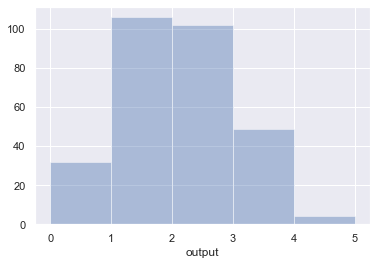

In [217]:
sns.distplot(y_syn_07d["output"],bins=[0,1,2,3,4,5],hist=True,kde=False)


In [227]:
svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
      shrinking=True,cache_size=50,verbose=False)
svr.fit(X_syn_07d,y_syn_07d["output"]) 
y_pred = svr.predict(X)
print(r2_score(y_b['output'],y_pred))

0.639883668182825


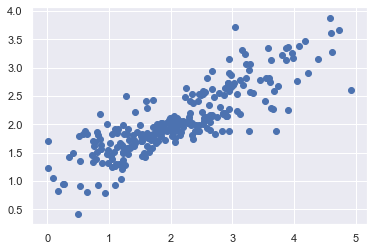

In [230]:
plt.scatter(y_b["output"],y_pred,cmap=plt.get_cmap("flag"))
plt.show()


In [232]:
X_syn_07e = X_syn_07d.copy()
X_syn_07e = X_syn_07e.append(X)
X_syn_07e

,0,1,2,3,4,5,6,7,8,9,...,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134
39,1,-1,1,0,0,-1,0,-1,0,0,...,0,-1,1,-1,-1,0,-1,-1,0,0
359,1,1,0,1,-1,-1,1,1,1,0,...,1,0,1,-1,0,0,-1,-1,1,0
559,0,0,1,0,-1,-1,1,0,0,-1,...,0,-1,1,-1,0,0,0,-1,1,0
879,1,1,0,1,-1,0,1,0,0,-1,...,1,-1,1,-1,0,0,-1,-1,1,0
919,1,0,1,0,0,-1,1,0,0,-1,...,0,-1,1,1,0,0,-1,-1,0,0
1159,1,1,1,-1,-1,0,1,-1,0,-1,...,1,-1,1,0,1,0,-1,-1,1,0
1239,0,1,1,0,-1,0,0,0,1,-1,...,0,-1,1,-1,-1,0,-1,-1,1,0
1559,0,1,0,1,-1,0,1,0,1,-1,...,1,-1,1,0,0,1,1,0,1,0
1639,1,0,0,0,-1,-1,1,0,0,-1,...,0,0,1,-1,0,1,0,0,1,0
1919,1,-1,0,0,-1,-1,1,1,1,1,...,1,1,1,-1,-1,-1,-1,-1,-1,0


In [235]:
X_syn_07e[X_syn_07e.duplicated()==True]

,0,1,2,3,4,5,6,7,8,9,...,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134
